In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import time
import sklearn.utils as sku


mockdata = np.load("../data/dataset_all_H1_bootstrap_O3a.npy")



In [2]:
mockdata[:,6]

array([3., 0., 0., ..., 3., 4., 5.])

In [3]:
mask = np.where(mockdata[:,6] > 0)
mockdata[:,6][mask] = 1

In [4]:
import networklib as nl
# Example usage
if __name__ == "__main__":
    # Synthetic dataset generation (replace with real data)
    # num_samples = 1000
    features = torch.tensor(mockdata[:, :6])  # First 6 columns for features
    labels = torch.tensor(mockdata[:, 6])     # 7th column for class labels (multiclass)


    
    # Ensure labels are integers (already assumed to be 0 to 6)
    # labels = labels.astype(torch.int64)  # Convert to int64 for PyTorch compatibility

    # features = torch.rand(num_samples, 6)  # 6 input features
    # labels = torch.randint(0, 2, (num_samples,))  # Binary classification (0 or 1)

    # shufflerows  = torch.randperm(features.size()[0])

    # Split dataset into training and validation sets
    dataset = TensorDataset(features.float(), labels.long())
    
    datasize = len(dataset)
    train_size = int(0.8 * datasize)
    val_size = int(0.1 * datasize)
    test_size = datasize - train_size - val_size
    print(test_size)

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=4128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4128, shuffle=False)
    nepochs = 100
    # Initialize and train the model
    # model = nl.GlitchClassifierDynamic(6, 16, 2)
    # print(dataset[train_dataset.indices][1])
    temp_class_weights = sku.class_weight.compute_class_weight({0:6,1:1}, classes=np.array([0,1]), y=mockdata[:,6][train_dataset.indices])

    class_weights = torch.tensor(temp_class_weights, dtype=torch.float32, device='cuda')

    model = nl.GlitchClassifier(6, 32, 2)
    trained_model, loss_list,train_loss_list,val_loss_list,precision_list,recall_list, accuracy_list  = nl.train_model(model, train_loader, val_loader, epochs=nepochs, lr=0.00001, device='cuda', weights = class_weights)


3780
Epoch 1/100, Train Loss: 1.1466, Val Loss: 1.8967, Precision: 0.1497, Recall: 0.0390, Accuracy: 0.8235
Epoch 2/100, Train Loss: 1.0614, Val Loss: 1.8555, Precision: 0.1491, Recall: 0.0426, Accuracy: 0.8209
Epoch 3/100, Train Loss: 1.0186, Val Loss: 1.8157, Precision: 0.1333, Recall: 0.0461, Accuracy: 0.8130
Epoch 4/100, Train Loss: 1.0080, Val Loss: 1.7773, Precision: 0.1267, Recall: 0.0496, Accuracy: 0.8071
Epoch 5/100, Train Loss: 0.9800, Val Loss: 1.7399, Precision: 0.1200, Recall: 0.0532, Accuracy: 0.8005
Epoch 6/100, Train Loss: 0.9387, Val Loss: 1.7039, Precision: 0.1176, Recall: 0.0567, Accuracy: 0.7958
Epoch 7/100, Train Loss: 0.9204, Val Loss: 1.6701, Precision: 0.1137, Recall: 0.0603, Accuracy: 0.7897
Epoch 8/100, Train Loss: 0.8850, Val Loss: 1.6373, Precision: 0.1161, Recall: 0.0691, Accuracy: 0.7825
Epoch 9/100, Train Loss: 0.8607, Val Loss: 1.6070, Precision: 0.1194, Recall: 0.0798, Accuracy: 0.7749
Epoch 10/100, Train Loss: 0.8416, Val Loss: 1.5796, Precision: 0.127

In [5]:
torch.save(model.state_dict, '../model/model-test-001/model.pt')

In [6]:
print((dataset[train_dataset.indices][1] == 0).sum())
print((dataset[train_dataset.indices][1] == 1).sum())

tensor(4273)
tensor(25967)


In [7]:
total_loss = np.array(loss_list)
train_loss = np.array(train_loss_list)
validation_loss = np.array(val_loss_list)
accuracy = np.array(accuracy_list)
precision = np.array(precision_list)
recall = np.array(recall_list)

In [8]:
device = 'cuda'

In [9]:
print(class_weights/class_weights.min())

tensor([6., 1.], device='cuda:0')


## Question
Isn't the test data not the same as the final validation of the model?

In [10]:
import confusion as con
import sklearn
test_loader = DataLoader(test_dataset, 256, False)



model.eval()

correct_tp = 0
correct_fp = 0
correct_fn = 0
correct_tn = 0
test_precision = 0
test_recall = 0
con_matrix = con.ConfusionMatrix(2)

for batch in test_loader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    clabels = labels.cpu().numpy()
    cpredicted = predicted.cpu().numpy()
    con_matrix.add(clabels, cpredicted)
    # print()

con_matrix.calculate()
test_accuracy = con_matrix.accuracy
test_precision = con_matrix.precision
test_recall = con_matrix.recall
    

print(con_matrix.predicted_class)
print(con_matrix.true_class)

epochs = np.arange(1, test_size+1, 1)
# plt.figure(figsize=(14,2))
# plt.scatter(epochs,con_matrix.true_class,s=1,marker="s")
# plt.scatter(epochs,con_matrix.predicted_class,s=1,marker="s")
# plt.scatter(epochs, con_matrix.true_class == con_matrix.predicted_class, s= 1, marker= 's')
# plt.scatter(epochs[con_matrix.true_class == 0], -0.5*np.ones_like(con_matrix.true_class)[con_matrix.true_class == 0], s = 1, marker = 's')

# plt.scatter(epochs, con_matrix.true_class - con_matrix.predicted_class)

print(len(con_matrix.true_class))
gravitational_wave_missclassified_as_noise = (con_matrix.predicted_class[con_matrix.true_class == 0] == 1).sum()
noise_missclassified_as_gravitational_wave = (con_matrix.predicted_class[con_matrix.true_class == 1] == 0).sum()
gravitational_wave_classified_correctly = (con_matrix.predicted_class[con_matrix.true_class == 0] == 0).sum()
noise_classified_correctly = (con_matrix.predicted_class[con_matrix.true_class == 1] == 1).sum()

print(gravitational_wave_missclassified_as_noise)
print(noise_missclassified_as_gravitational_wave)
print(gravitational_wave_classified_correctly)
print(noise_classified_correctly)

print(gravitational_wave_missclassified_as_noise/(con_matrix.true_class == 0).sum())
print(noise_missclassified_as_gravitational_wave/(con_matrix.true_class == 1).sum())

print(noise_missclassified_as_gravitational_wave/(gravitational_wave_classified_correctly+noise_missclassified_as_gravitational_wave))
# print(test_precision, test_recall, test_accuracy)
# print(con_test_precision, con_test_recall, con_test_accuracy)

[0 1 1 ... 0 0 0]
[1 1 1 ... 1 1 1]
3780
160
1047
403
2170
0.2841918294849023
0.3254585017096674
0.7220689655172414


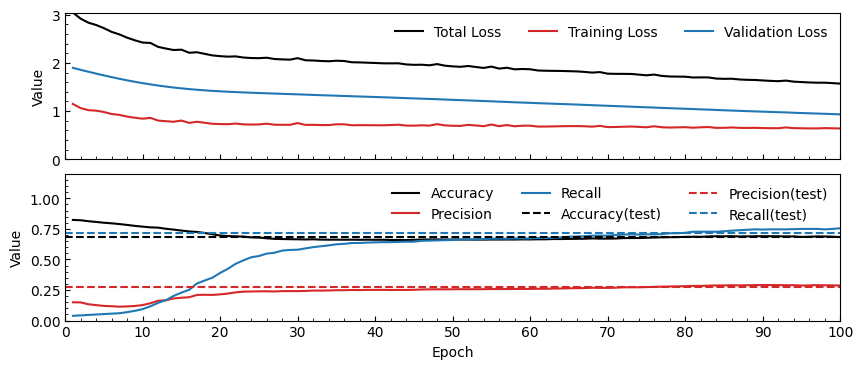

In [27]:

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


epochs = np.arange(1, nepochs+1, 1)


fig, ax = plt.subplots(2, 1, squeeze=  False, figsize = (10, 4),sharex=True)
ax[0,0].plot(epochs, total_loss, label = r"Total Loss", zorder= 1, color = "k")
ax[0,0].plot(epochs, train_loss, label = r"Training Loss",zorder = 1, color = "tab:red")
ax[0,0].plot(epochs, validation_loss, label = r"Validation Loss",zorder = 1, color = "tab:blue")
ax[1,0].plot(epochs, accuracy, label = r"Accuracy",zorder = 1, color = "k")
ax[1,0].plot(epochs, precision, label = r"Precision",zorder = 1, color = "tab:red")
ax[1,0].plot(epochs, recall, label = r"Recall",zorder = 1, color = "tab:blue")

ax[1,0].axhline(test_accuracy, label = r"Accuracy(test)", zorder = 1, color = "k", linestyle = "dashed")
ax[1,0].axhline(test_precision, label = r"Precision(test)", zorder = 1, color = "tab:red", linestyle = "dashed")
ax[1,0].axhline(test_recall, label = r"Recall(test)", zorder = 1, color = "tab:blue", linestyle = "dashed")

# ax[0,0].axhline((total_loss).mean(),zorder= 0,color = "k", linestyle = "dotted")
# ax[0,0].axhline((total_accuracy).mean(),zorder= 0,color = "k", linestyle = "dotted")
ax[0,0].set_ylabel(r"Value")
ax[1,0].set_ylabel(r"Value")
for i in range(2):
    ax[i,0].tick_params(axis="y",direction="in",which="both")
    ax[i,0].tick_params(axis="x",direction="in",which="both")
    # ax[i,0].set_yticks(np.arange(0, np.max(total_loss), int(np.max(total_loss)) /10))
    ax[i,0].set_xticks(np.arange(0, nepochs + 1, nepochs // 10))
    ax[i,0].xaxis.set_minor_locator(MultipleLocator(nepochs//50))
    ax[i,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].set_xlabel(r"Epoch")
# ax[0,0].set_ylabel("Value")
ax[0,0].set_xlim(0, nepochs)
ax[0,0].set_ylim(0, np.max(total_loss))
ax[1,0].set_ylim(0, 1.2)
ax[0,0].legend(frameon=False, ncol=3)
ax[1,0].legend(frameon=False, ncol=3)
fig.subplots_adjust(hspace=0.1)

fig.savefig("../model/model-test-001/figures/performance-overview-1.pdf")

# ax[0,0].grid(True,which="minor")

In [12]:
tgw = 0
ngw = 0

for batch in test_loader:
    inputs, labels=batch
    tgw += (labels == 0).sum()
    ngw += (labels == 1).sum()

print(tgw, ngw)


tensor(563) tensor(3217)


In [13]:
test_dataset

In [14]:
test_features = torch.tensor([])
test_labels = torch.tensor([])


for batch in test_loader:
    temp_features, temp_labels = batch
    test_features = torch.concatenate((test_features, temp_features))
    test_labels = torch.concatenate((test_labels, temp_labels))
tmodel = trained_model.to(device)
tmodel.eval()
logits = tmodel(test_features.to(device).float())
probs = torch.softmax(logits, dim=1).cpu().detach().numpy()

In [15]:
mask = np.where(test_labels.cpu().numpy() == 0)
features_0 = features[mask]
p_0 = probs[:,0][mask]
mask = np.where(test_labels.cpu().numpy() == 1)
features_1 = features[mask]
p_1 = probs[:,1][mask]



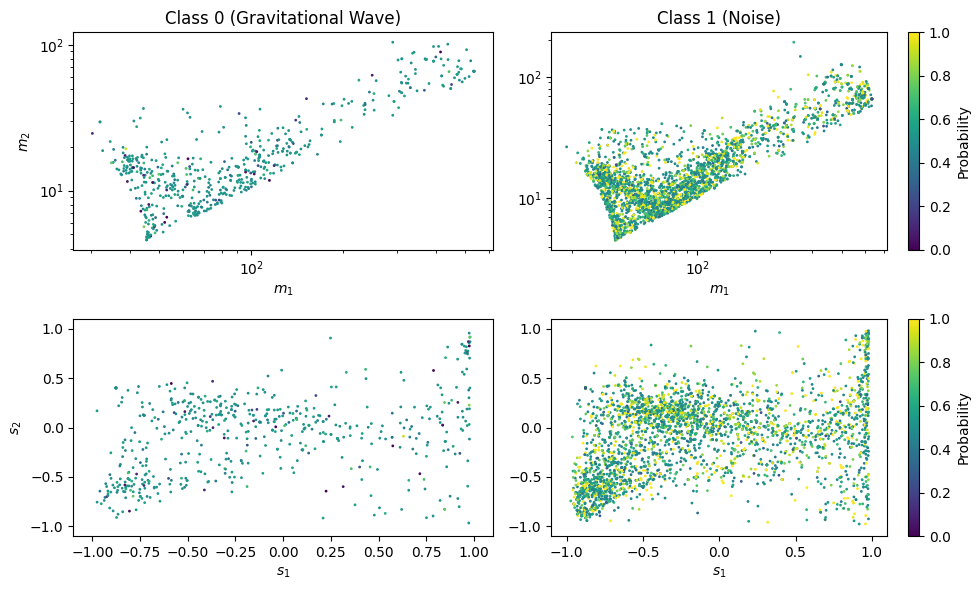

In [16]:
fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(10, 6))

# Scatter plots with individual color maps
scatter_0 = ax[0, 0].scatter(features_0[:,2], features_0[:,3], c=p_0, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
scatter_1 = ax[0, 1].scatter(features_1[:,2], features_1[:,3], c=p_1, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))

scatter_3 = ax[1, 0].scatter(features_0[:,4], features_0[:,5], c=p_0, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
scatter_4 = ax[1, 1].scatter(features_1[:,4], features_1[:,5], c=p_1, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))

# Add a colorbar to the entire figure
cbar = fig.colorbar(scatter_0, ax=ax[0,1], shrink=1)
cbar2 = fig.colorbar(scatter_3, ax=ax[1,1], shrink=1)
cbar.set_label("Probability")
cbar2.set_label("Probability")
# Titles, labels, and adjustments
ax[0,0].set_title("Class 0 (Gravitational Wave)")
ax[0,0].set_xlabel("$m_{1}$")
ax[0,0].set_ylabel("$m_{2}$")
ax[0,0].loglog()
ax[0,1].set_title("Class 1 (Noise)")
ax[0,1].set_xlabel("$m_{1}$")
ax[0,1].loglog()


ax[1,0].set_ylabel("$s_{2}$")
ax[1,0].set_xlabel("$s_{1}$")
ax[1,1].set_xlabel("$s_{1}$")

ax[1,0].set_xlim([-1.1,  1.1])
ax[1,1].set_xlim([-1.1,  1.1])
ax[1,0].set_ylim([-1.1,  1.1])
ax[1,1].set_ylim([-1.1,  1.1])
plt.tight_layout()
plt.show()



/tmp/ipykernel_7233/3871048506.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_0 = ax[0, 0].scatter(features_0[:,2], features_0[:,3], s=1, cmap='viridis', color = 'green')
/tmp/ipykernel_7233/3871048506.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_1 = ax[0, 0].scatter(features_1[:,2], features_1[:,3], s=1, cmap='viridis', color = 'red')
/tmp/ipykernel_7233/3871048506.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_3 = ax[1, 0].scatter(features_0[:,4], features_0[:,5], s=1, cmap='viridis', color = 'green')
/tmp/ipykernel_7233/3871048506.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_4 = ax[1, 0].scatter(features_1[:,4], features_1[:,5], s=1, cmap='viridis', color = 'red')


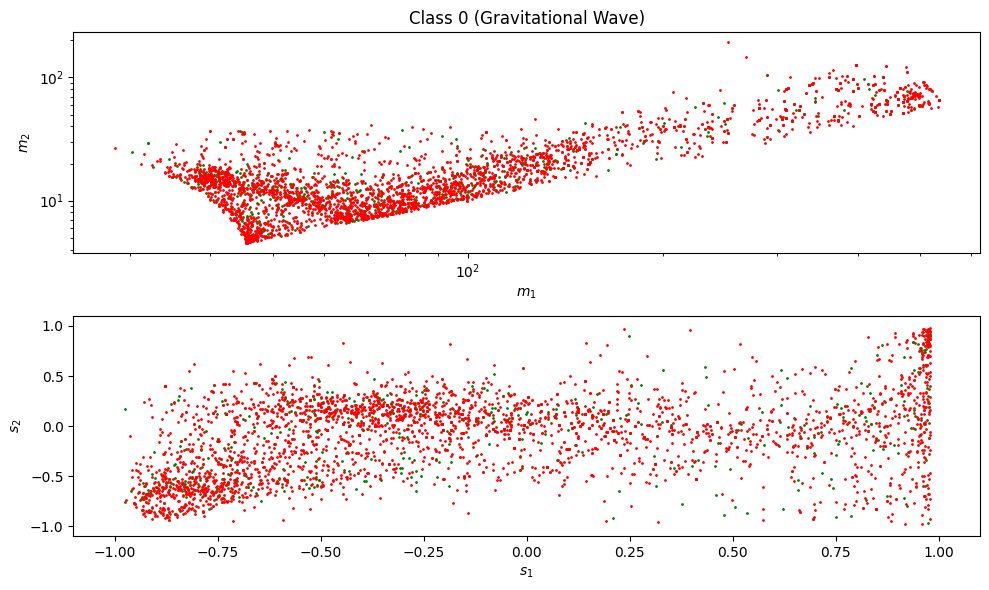

In [17]:
fig, ax = plt.subplots(2, 1, squeeze=False, figsize=(10, 6))

# Scatter plots with individual color maps
scatter_0 = ax[0, 0].scatter(features_0[:,2], features_0[:,3], s=1, cmap='viridis', color = 'green')
scatter_1 = ax[0, 0].scatter(features_1[:,2], features_1[:,3], s=1, cmap='viridis', color = 'red')

scatter_3 = ax[1, 0].scatter(features_0[:,4], features_0[:,5], s=1, cmap='viridis', color = 'green')
scatter_4 = ax[1, 0].scatter(features_1[:,4], features_1[:,5], s=1, cmap='viridis', color = 'red')

# Add a colorbar to the entire figure
# cbar = fig.colorbar(scatter_0, ax=ax[0,1], shrink=1)
# cbar2 = fig.colorbar(scatter_3, ax=ax[1,1], shrink=1)
cbar.set_label("Probability")
cbar2.set_label("Probability")
# Titles, labels, and adjustments
ax[0,0].set_title("Class 0 (Gravitational Wave)")
ax[0,0].set_xlabel("$m_{1}$")
ax[0,0].set_ylabel("$m_{2}$")
ax[0,0].loglog()
# ax[0,1].set_title("Class 1 (Noise)")
# ax[0,1].set_xlabel("$m_{1}$")
# ax[0,1].loglog()


ax[1,0].set_ylabel("$s_{2}$")
ax[1,0].set_xlabel("$s_{1}$")
# ax[1,1].set_xlabel("$s_{1}$")

ax[1,0].set_xlim([-1.1,  1.1])
# ax[1,1].set_xlim([-1.1,  1.1])
ax[1,0].set_ylim([-1.1,  1.1])
# ax[1,1].set_ylim([-1.1,  1.1])
plt.tight_layout()
plt.show()

